# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
# %%writefile src/train/text_utils.py
import re
import pyonmttok
from src.train.nlp_utils import load_lemmatizers, get_tokens, select_lemmas


def process_topics(topics):
    ''' remove empty ones and strip from whitespaces '''
    topics = list(filter(lambda x: x != '', 
                        topics))
    topics = list(map(lambda x: x.strip(), topics))
    return topics


def raw2list(raw):
    """convert raw str or dict field to a list of topics """
    if isinstance(raw, dict):
        raw = raw['choices']
    else:
        raw = [str(raw)]
    return raw


def get_test_topics(primary, secondary):
    """ merge primary and secondary """
    primary = raw2list(primary)
    if secondary != '':
        primary += raw2list(secondary)
    return primary


def prepare_inputs(channel_data, target_fields):
    """ receive one channel example and return its texts from title, description and posts """
    inputs = []
    if 'title' in target_fields:
        inputs.append(channel_data['title'])
    if 'description' in target_fields:
        inputs.append(channel_data['description'])
    if 'posts' in target_fields:
        inputs += list(channel_data['posts'])
    return '\n'.join(inputs)


def clean_token(token):
    """ keep only english or russian characters """
#     re.sub('[\W\d]', '', x)
    token = re.sub('[^a-zа-я]', '', token)
    return token


def process_tokens(tokens):
    """filter out useless tokens as empty or non-words"""
    tokens = list(map(lambda x: clean_token(x),
                     tokens))
    tokens = list(filter(lambda x: len(x) > 1,
                    tokens))
    return tokens


TOKENIZER = pyonmttok.Tokenizer('aggressive', joiner_annotate=True)


def preprocess_text(text):
    """remove url, non-words chars """
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
             " ", text)
    return text.lower()

def tokenize_text(text):
    """ split into lowercase tokens """
    text = preprocess_text(text)
    tokens,_ = TOKENIZER.tokenize(text)
    tokens = process_tokens(tokens)
    return tokens


POS = {
    "en": ['NOUN', 'PROPN', 'ADJ', 'VERB'],
    "ru": ['A', 'S',]
}

load_lemmatizers()


def lang_lemmatizer(language):
    def lemmatize_text(text):
        """ get lemmas and POS tags, select target POS lemmas and filter trash """
        text = preprocess_text(text)
        tokens = get_tokens(text, language)
        lemmas = select_lemmas(tokens, POS[language])
        lemmas = process_tokens(lemmas)
        return lemmas
    return lemmatize_text

## Data prep

In [13]:
POSTS = 'data/raw/posts.csv'
META = 'data/raw/meta.csv'
TOPICS = 'data/external/telegram_channels.csv'

COMPLETIONS = [
    'data/external/2020-02-09_completions.json',
    'data/external/2020-02-13_active_completions.json',
]

ONLY_PRIMARY = False

### Load channels

In [14]:
posts = pd.read_csv(POSTS)
meta = pd.read_csv(META)
topics = pd.read_csv(TOPICS)

# extra columns
topics['topic [Secondary]'].fillna("", inplace=True)
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])

topics['language'] = topics['language'].apply(lambda x: x.lower()[:2])

posts.rename({'channel':'username', 'message': 'posts'}, axis=1, inplace=True)

if ONLY_PRIMARY:
    topics['topics'] = topics.apply(lambda x: x['topic [Primary]'].split(','), axis=1)
else:
    topics['topics'] = topics.apply(lambda x: x['topic [Primary]'].split(',') + x['topic [Secondary]'].split(','), 
                               axis=1)
topics['topics'] = topics['topics'].apply(process_topics)
posts['posts'].fillna("", inplace=True)

meta['description'] = meta['about']
meta['description'].fillna('', inplace=True)


del topics['link'], meta['about']

In [15]:
posts.sample(4)

,username,idx,date,posts,language
2869,English,443,2020-02-23 17:53:54+00:00,,en
4507,lektorium,745,2021-01-28 08:00:18+00:00,Программистов не хватает.\n\nОткрываются новые...,ru
4545,gosuslugiforparents,481,2021-02-08 10:00:17+00:00,"📌 5 льгот для семей с детьми, о которых вы мог...",ru
893,Rabota_Kazan_116,1575,2021-02-11 07:00:09+00:00,Вебкам студия в Казани TrueLove проводит набор...,ru


In [16]:
meta.sample(3)

,username,title,description
373,animalstoday,Animals Today,Cute animals that the @PrivacyToday chat has s...
496,rsgg2020,Russian Startups Go Global,Канал «Акселератора ФРИИ» о выходе IT-компаний...
221,internationalgeographic,International Geographic,We travel to the most beautiful places in the ...


In [17]:
topics.sample(5)

,Timestamp,topic [Primary],language,topic [Secondary],username,topics
220,2/6/2021 18:51:08,History,ru,,russian_culture,[History]
127,2/8/2021 8:01:56,Celebrities & Lifestyle,ru,,life_stars_online,[Celebrities & Lifestyle]
178,2/8/2021 6:48:33,Cars & Other Vehicles,en,,moto_channel,[Cars & Other Vehicles]
153,2/8/2021 7:20:07,Books,ru,,ikniga,[Books]
201,2/6/2021 19:07:49,Fitness,ru,,fitness_sport_zozh,[Fitness]


### EDA

In [18]:
from src.train.plot_utils import barplots

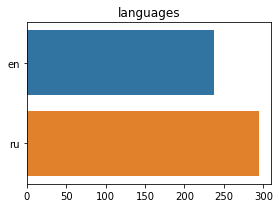

In [19]:
barplots({
    'languages': topics['language']
}, 1, 1)

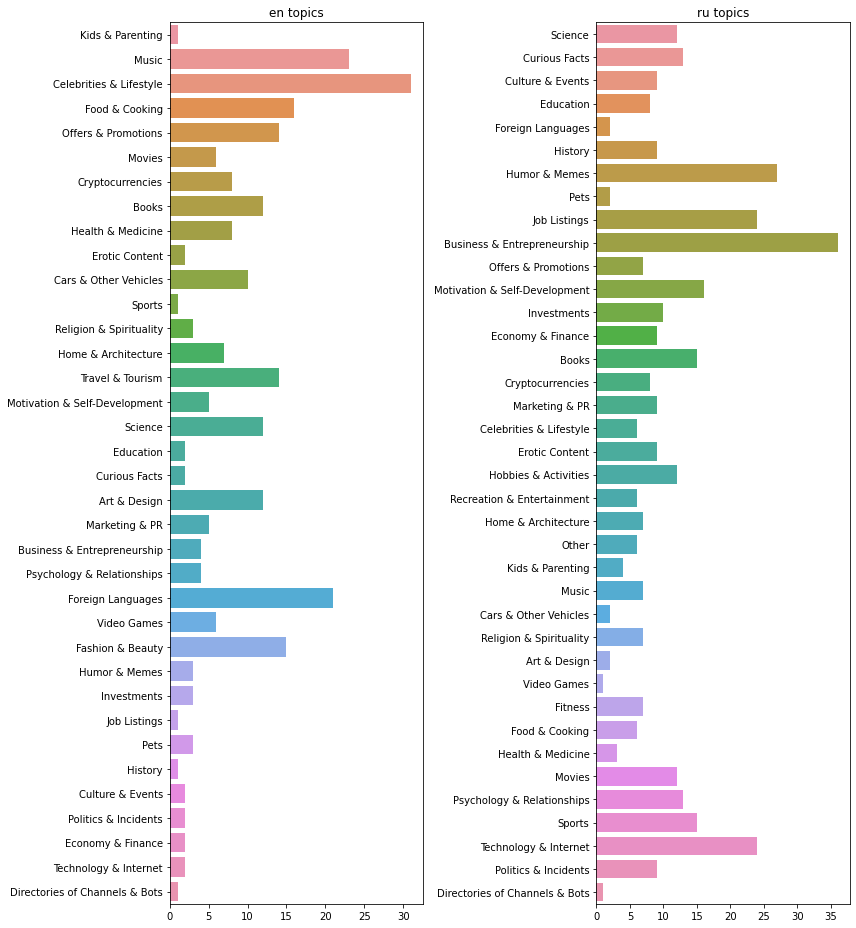

In [20]:
t = topics.groupby('language').agg({
    'topics': lambda rows: Counter(x for row in rows for x in row)
}).to_dict()['topics']

barplots({
    'en topics': (list(t['en'].keys()), list(t['en'].values())),
    'ru topics': (list(t['ru'].keys()), list(t['ru'].values())),
}, 1, 2, fig_dims=(12,13))

In [21]:
posts.groupby('language').agg({'username':['count', 'nunique']})

username        
            count nunique
language                 
en           2273     228
ru           2774     278

### Compare raw tokens to lemmas

In [24]:
row = posts.sample(1).iloc[0]

lem = lang_lemmatizer(row['language'])
l = lem(row['posts'],)
t = tokenize_text(row['posts'])

print("INPUT", row['posts'], end='\n\n')
print("LEMMAS", l)
# pprint(l)
print('\nRAW TOKENS', t)
# pprint(t)

INPUT Всем салют! вроде выздоровел, очень круто и приятно получать живую обратную связь на посты и видео с Ваней Замесиным, спасибо всем за ценные мысли 💥💥💥

Об этом пишут редко, но кратный рост продукта, который прошел начальные стадии, лежит внутри клиентской команды: это может быть саппорт, аккаунты, продавцы. У нас в Рике клиентская команда — это команда заботы.

Спойлер: отличный повод поделится полезным — рассказать, что меня бомбит, особенно когда у нас есть три открытые вакансии (ссылки на них будут в конце поста 👀)

Если вы думаете, что у вашего продукта нет проблем, влияющих на доходы — вы давно не отвечали пользователям в команде заботы и скорее всего спрятались от нее за 2-3 тикет системами, чтобы ни в коем случае не вырывать себя из мира розовых пони.

LEMMAS ['салют', 'живой', 'обратный', 'связь', 'пост', 'видео', 'ваня', 'замесин', 'спасибо', 'ценный', 'мысль', 'кратный', 'рост', 'продукт', 'начальный', 'стадия', 'клиентский', 'команда', 'саппорт', 'аккаунт', 'продавец',

### Build a dataframe

In [25]:
train_channels = topics[['username', 'topics', 'language']].to_dict('records')
channel_meta = meta.groupby('username').agg({
                            'title': 'first',
                            'description': 'first'
                            }).to_dict('index')

len(train_channels), len(channel_meta)

(532, 506)

In [30]:
inputs = []

for channel in tqdm_notebook(train_channels, desc='channels'):
    channel_name = channel['username']
    subset = posts.query(f'username == "{channel_name}"')['posts']
    num_smp = min(len(subset), np.random.randint(1, 10))
    smp = subset.sample(num_smp).tolist()
    for top in channel['topics']:
        one = {
            'username': channel_name,
            'language': channel['language'],
            'posts': smp,
            'title': channel_meta[channel_name]['title'],
            'description': channel_meta[channel_name]['description'],
            'topic': top,
        }
        inputs.append(one)
    
inputs = pd.DataFrame(inputs)


/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


channels:   0%|          | 0/532 [00:00<?, ?it/s]

### Test data

In [31]:
labelled_data = [pd.read_json(c, ) for c in COMPLETIONS]

labelled_data = pd.concat(labelled_data)
labelled_data['secondary'].fillna('', inplace=True)
labelled_data['username'] = '???'
del labelled_data['posts']
labelled_data.rename({'lang_code': 'language', 'recent_posts': 'posts'}, axis='columns', inplace=True)


labelled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 0 to 153
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  564 non-null    object 
 1   language     564 non-null    object 
 2   posts        564 non-null    object 
 3   title        564 non-null    object 
 4   id           564 non-null    int64  
 5   primary      564 non-null    object 
 6   secondary    564 non-null    object 
 7   predictions  154 non-null    object 
 8   score        154 non-null    float64
 9   username     564 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 48.5+ KB


In [32]:
labelled_data['topics'] = labelled_data.apply(lambda x: get_test_topics(x['primary'], 
                                                                '' if ONLY_PRIMARY else x['secondary']),
                                  axis=1)

In [33]:
labelled_data.groupby('language').agg({
    'language': 'count',
}).to_dict()

{'language': {'en': 279, 'ru': 285}}

In [34]:
test_data = []

for i, row in labelled_data.iterrows():
    for top in row['topics']:
        row['topic'] = top
        test_data.append(row)
        

test_data = pd.DataFrame(test_data)

### Topic distribution

In [35]:
from src.train.plot_utils import barplots

ru


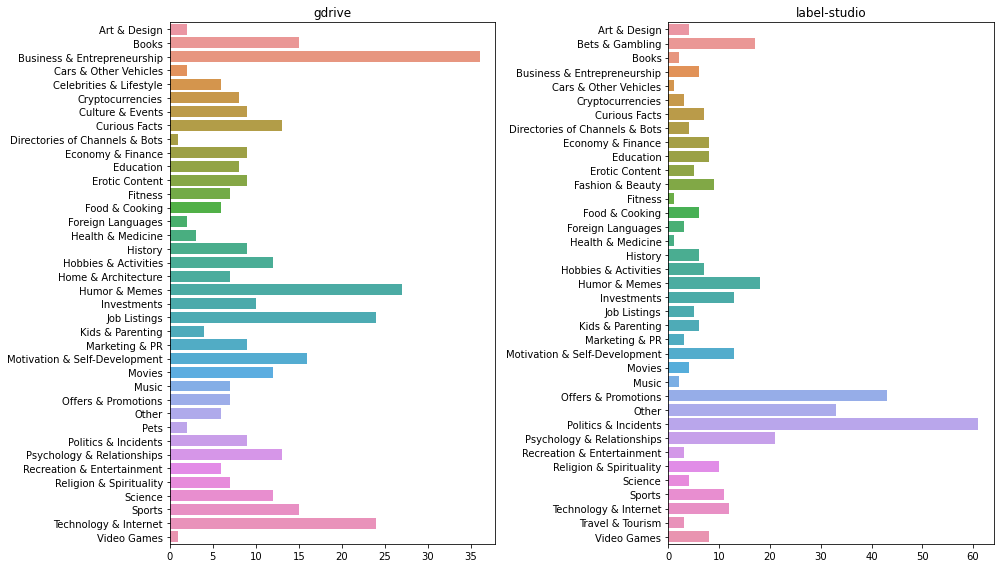

en


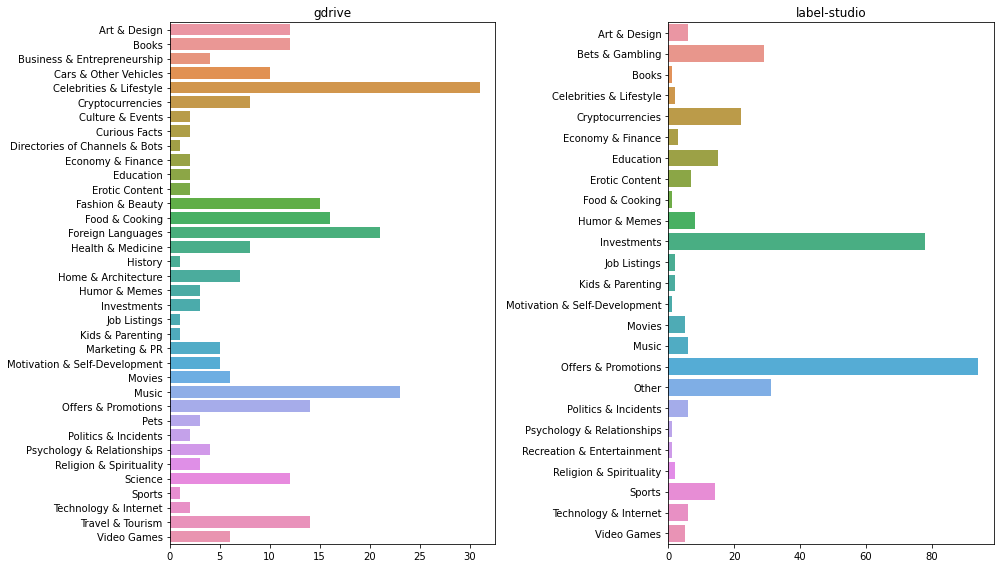

In [36]:
for l in test_data['language'].unique():
    print(l)
    barplots({
        'gdrive': inputs.query(f"language == '{l}'")['topic'],
        'label-studio': test_data.query(f"language == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8))

In [37]:
inputs['topic'].nunique(), test_data['topic'].nunique(),

(40, 38)

### Save combined

In [38]:
comb = pd.concat([inputs, test_data], axis=0)
comb.shape

(1358, 12)

In [39]:
comb.to_csv('data/interim/train_data.csv', index=False)

### Load stopwords

In [40]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
}

In [41]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

332

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [42]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [43]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, language, input_fields, preprocessing, vect, est):
        self.LANG = language
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(language)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        # text inputs and 
        inputs['text'] = inputs.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        test_data['text'] = test_data.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        # split into  train and test
        test_subset = test_data.query(f"language == '{self.LANG}'")
        external_subset = inputs.query(f"language == '{self.LANG}'")
        one,self.test_inputs = train_test_split(test_subset, test_size=TEST_SIZE, random_state=24, shuffle=True,)
        comb_datasets = [external_subset, one, self.test_inputs] if is_final else [external_subset, one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['topic']
        self.y_test = self.test_inputs['topic']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['topics'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] in x['true'], axis=1).mean()
        return score

### Set hyper-parameters

In [73]:
TEST_SIZE = 0.5

In [80]:
INPUTS = [
    'title',
    'description',
    'posts',
]

PREPROCESSING = [
    'raw',
    'lemma',
]

vect_params = dict(
    max_df=0.6, 
    min_df=2,
    max_features=2000,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [81]:
input_combinations = list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product(test_data['language'].unique(), 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

64

### Run experiments

In [82]:
results = []

for params in tqdm_notebook(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['language','input_fields', 'preprocessing','vect', 'est', 'score'])

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# experiments:   0%|          | 0/64 [00:00<?, ?it/s]

In [83]:
for l in results['language'].unique():
    print(results.query(f'language == "{l}"').sort_values('score', ascending=False).to_markdown(), end='\n\n')

|    | language   | input_fields                      | preprocessing   | vect   | est   |    score |
|---:|:-----------|:----------------------------------|:----------------|:-------|:------|---------:|
| 12 | ru         | ('title', 'posts')                | lemma           | tfidf  | cnb   | 0.666667 |
| 28 | ru         | ['title', 'description', 'posts'] | lemma           | tfidf  | cnb   | 0.666667 |
| 31 | ru         | ['title', 'description', 'posts'] | lemma           | bow    | mnb   | 0.655914 |
| 15 | ru         | ('title', 'posts')                | lemma           | bow    | mnb   | 0.639785 |
| 20 | ru         | ('description', 'posts')          | lemma           | tfidf  | cnb   | 0.629032 |
| 23 | ru         | ('description', 'posts')          | lemma           | bow    | mnb   | 0.61828  |
| 30 | ru         | ['title', 'description', 'posts'] | lemma           | bow    | cnb   | 0.602151 |
| 24 | ru         | ['title', 'description', 'posts'] | raw             | tfidf  |

### Review errors

In [84]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [85]:
trainer = Trainer(
    language = 'ru', 
    input_fields = ['posts','description','title'], 
    preprocessing = 'raw',
    vect = 'tfidf', 
    est = 'cnb'
)
s = trainer.run_eval(final=False)
print(s)

0.632183908045977


In [113]:
for k in [1,2,3,5]:
    top_k_acc = top_k_accuracy_score(trainer.y_test, trainer.clf.predict_proba(trainer.X_test), 
                                     labels=trainer.clf.classes_,
                                        k=k)
    print(f'Top {k} accuracy: {top_k_acc:.2f}', )

Top 1 accuracy: 0.53
Top 2 accuracy: 0.66
Top 3 accuracy: 0.73
Top 5 accuracy: 0.76


#### Classification report

In [114]:
from sklearn.metrics import classification_report

In [115]:
test_pred = trainer.clf.predict(trainer.X_test)

is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


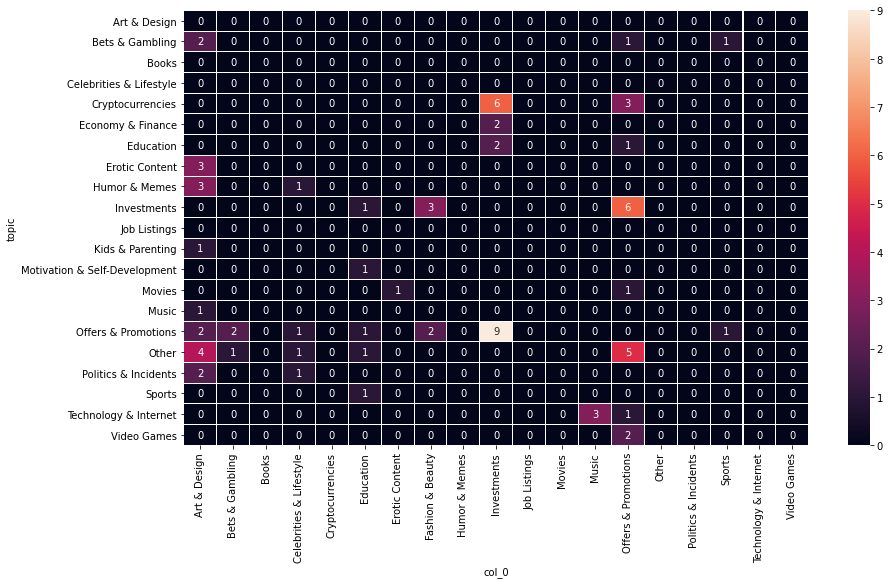

In [116]:
ct = pd.crosstab(trainer.y_test, test_pred)
for i,k in ct.iteritems():
    k[i] = 0


plt.figure(figsize=(14,8))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [117]:
metrics = pd.DataFrame(classification_report(trainer.y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                               |   precision |   recall |   f1-score |   support |
|:------------------------------|------------:|---------:|-----------:|----------:|
| Kids & Parenting              |    0        | 0        |   0        |   1       |
| Music                         |    0        | 0        |   0        |   1       |
| Motivation & Self-Development |    0        | 0        |   0        |   1       |
| Economy & Finance             |    0        | 0        |   0        |   2       |
| Other                         |    1        | 0.142857 |   0.25     |  14       |
| Art & Design                  |    0.142857 | 1        |   0.25     |   3       |
| Erotic Content                |    0.5      | 0.25     |   0.333333 |   4       |
| Humor & Memes                 |    1        | 0.2      |   0.333333 |   5       |
| Celebrities & Lifestyle       |    0.2      | 1        |   0.333333 |   1       |
| Technology & Internet         |    1        | 0.2      |   0.333333 |   5 

#### random examples

In [119]:
row = errors.sample(1).iloc[0]

print('PREDICTED:\n', row['predicted'], end='\n\n')
print('TRUE:\n', row['topics'], end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
print('DESCRIPTION:\n', row['description'], end='\n\n')

PREDICTED:
 Offers & Promotions

TRUE:
 ['Technology & Internet', 'Other']

TEXTS:
 【NOOB SCRIPT LOVERS】™√
【 A l l    S C R I P T 】

【 S C R I P T    LO V E R S 】

【N E W   R E F A R AND    E A R N I NG 
                                    A P P S 】
 
 [C O N T A C T ] 【  @Loot_king_bot】
Mamber looted proof😍😍
http://t.me/NOOBSCRIPTAR

Aaj ke task complete karo dosto,
🎁 Rs.4 :
https://www.fiewin.com/#/LR?no=luckyC9dj&ic=0QSN
• New Colour Prediction Website

• Singup :- ₹200

• Per Refer - Commission

• Min Withdraw - ₹500

• Link:-
https://luckygold.in/#/register?r_code=2176

•Singup bonnus Only first 10000 user ke liye

•Wait 10 Min Singup Bonus Automatically Added

•Joined more.
http://t.me/NOOBSCRIPTAR
• New Updates Now

• Singup Claim

• Per Refer - ₹5

• 3 Level Income

• Min Withdraw - ₹150

• Link:-
https://share.inpower.co.in/dist/index.html#/login?code=1386754

• #JoinNow
http://t.me/NOOBSCRIPTAR
• New Like Website

• Site Name :- Task999

• Daily 2 Tasks - ₹20

• Min Withdraw 

In [120]:
def get_topic_features(nb_clf, class_label, top_n=15):
    """ get features with largest log prob for the given class """
    class_i = np.argwhere(nb_clf.classes_ == class_label).squeeze()
    class_coef = nb_clf.feature_log_prob_[class_i]
    top_inds = np.argsort(class_coef)[-top_n:]
    return top_inds

In [121]:
FEATURES = trainer.vect.get_feature_names()
PREDICTED_INDEX = np.argwhere(trainer.clf.classes_ == row['predicted']).squeeze()

# get top features that triggered prediction
x = trainer.vect.transform([row['text']]).toarray()[0]
f = ( trainer.clf.feature_log_prob_ * x.T)[PREDICTED_INDEX]
top_keywords = [FEATURES[i] for i in np.argsort(f)[::-1][:15]]


true_inds = get_topic_features(trainer.clf, row['topic'],)
true_keywords = [FEATURES[i] for i in true_inds]

predicted_inds = get_topic_features(trainer.clf, row['predicted'],)
predicted_keywords = [FEATURES[i] for i in predicted_inds]


print('TRUE CLASS: ', row['topic'])
print(true_keywords, end='\n\n')
print(f'PREDICTED CLASS: {row["predicted"]}')
print(predicted_keywords, end='\n\n')
print('EXAMPLE')
print(top_keywords)

TRUE CLASS:  Other
['aimbot', 'netherlands', 'iran', 'commodities', 'consistently', 'familiar', 'crafted', 'tampa', 'tokyo', 'myanmar', 'flowers', 'mod', 'backedup', 'recoil', 'born']

PREDICTED CLASS: Offers & Promotions
['nifty', 'rummy', 'minning', 'klv', 'reff', 'termux', 'recharge', 'login', 'loot', 'chng', 'banknifty', 'paytm', 'protocol', 'announcements', 'cbpk']

EXAMPLE
['singup', 'withdraw', 'min', 'refer', 'website', 'commission', 'login', 'link', 'code', 'joined', 'bonus', 'ke', 'tasks', 'new', 'register']


#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [52]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [144]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x):
        jll = torch.matmul(x, self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.log(torch.sum(torch.exp(jll), dim=1))
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vectorizer):
        super().__init__()
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        self.idf_diag = nn.Parameter(
            torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
            requires_grad=False)
        self.sublinear_tf = vectorizer.sublinear_tf
        self.norm = vectorizer.norm
        self.use_idf = vectorizer.use_idf
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.double)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts, )
        if self.sublinear_tf:
            X = torch.log(X)
            X += 1
        if self.use_idf:
            X = torch.matmul(X, self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X, p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if probs.std(0) < 0.0001:
            return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [145]:
tgcat = TgCat(TextVectorizer(trainer.vect), NaiveBayes('cnb', trainer.clf), top_k=3)

In [146]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [147]:
tgcat([['a','bs','dd'], [""], ["other", 'other', 'ttt']])

[{'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}]

In [159]:
p = tgcat.get_prob(batch)

In [184]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'Education': 0.3821241005785637, 'Investments': 0.31769373715142835, 'Other': 0.3001821622700078}

TOKENS ['mission', 'net', 'physics', 'exam', 'rd', 'february', 'free', 'live', 'sessions', 'am', 'use', 'code', 'anjaliarora', 'to', 'join', 'the', 'following', 'free', 'live', 'sessions', 'pm', 'pm', 'thankyou', 'everyone', 'hello', 'everyone', 'get', 'ready', 'for', 'the', 'pm', 'very', 'important', 'free', 'live', 'session', 'last', 'moment', 'preparation', 'for', 'the', 'gate', 'physics', 'exam', 'use', 'code', 'anjaliarora', 'to', 'join', 'the', 'following', 'free', 'live', 'session', 'link', 'thankyou', 'everyone']


### Final training, convert and save

In [185]:
prediction_params = {
    'top_k': 3
}

In [157]:
for l in results['language'].unique():
    subset = results.query(f"language == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(trainer.vect), )
    tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    assert np.allclose(trainer.X_test.toarray(), vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray()))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru 0.98
saved to models/trained/tgcat/ru_tgcat.pt
en 0.95
saved to models/trained/tgcat/en_tgcat.pt


### Check file sizes

In [362]:
!du -hk models/trained/*/* | sort -nr

32832	models/trained/tgcat/ru_tgcat.pt
32832	models/trained/tgcat/en_tgcat.pt
31808	models/trained/embed/ru_tfidf_script.pt
31808	models/trained/embed/en_tfidf_script.pt
704	models/trained/classify/ru_cnb_script.pt
640	models/trained/classify/en_cnb_script.pt
44	models/trained/embed/ru_tfidf.txt
28	models/trained/embed/en_tfidf.txt
4	models/trained/embed/ru_bow.txt


In [363]:
!du -m data/*/* | sort -nr

174	data/external/dc0130-input.txt
172	data/external/dc0202-input.txt
113	data/external/dc0206-input.txt
6	data/interim/train_data.csv
4	data/raw/posts.csv
4	data/raw/backup
4	data/external/2020-02-09_completions.json
3	data/external/2020-02-06_completions.json
1	data/raw/meta.csv
1	data/processed/ru_predictions.json
1	data/processed/labelling_tasks_sample.json
1	data/processed/labelling_config.xml
1	data/processed/en_predictions.json
1	data/external/telegram_channels.csv
1	data/external/ru_stopwords.txt
1	data/external/en_stopwords.txt
1	data/external/dc0130_language_predictions.txt
